In [ ]:
# INSTALL APPLICABLE PACKAGES ON COLAB RUNTIME

# #This section is base copy from google's sample import of tensorflow, keras, ploting and support libraries

#keras install libraries
!pip install keras -U
!pip install tensorflow -U

#openCV is used to process and filter images
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc2)


In [ ]:
# IMPORT PYTHON LIBRARIES
# This cell contains all the references to libraries that are needed to train a convolutional neural network
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
import copy
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle
from sklearn import preprocessing

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense

In [ ]:
# MOUNT GOOGLE DRIVE
# Follow instructions as prompted after running code

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
figdata = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/CS236_Tests/tape_sr=7000_str=2800_14ms_6deg.npy')
fig, axs = plt.subplots(1, 2)
x = np.arange(start=0,stop=600/2800,step=1/2800)
cnt = 0
for i in range(2):
  y = figdata[0,0:600]
  axs[i].plot(x,y)
  cnt += 1
#fig.suptitle('Real Signal', fontsize=22)
fig.tight_layout()
#axs[0].set_ylabel ("Voltage (V)", fontsize=22)
#fig.text(0.5,0.04,"Time (sec)",ha='center',va='center',fontsize=22)
fig.savefig("tape_signal.png", dpi=300)
plt.close()

In [ ]:
# Create a list of tuples containing stall information
speeds = [10, 12, 14, 16, 18, 20]
aoas = range(0, 21, 2)
stall_dict = dict()
for speed in speeds:
  for aoa in aoas:
    if aoa < 17:
      stall_dict["{}ms_{}deg".format(speed,aoa)] = "no-stall"
    else:
      stall_dict["{}ms_{}deg".format(speed,aoa)] = "stall"
#Process exceptions:
stall_dict ["10ms_16deg"] = "stall"

In [ ]:
# PROCESS OUTPUT FILES INTO TRAINING EXAMPLES
# speedRange and aoaRange exists to filter-out noisy data
# mode is either one of these: 'stall', 'flutter', 'state'
def getData(Xdir, stall_dict, speedRange, aoaRange, incSensors):
  allXdata = [f for f in listdir(Xdir) if f != 'datafacts.txt' and f != "allExamples"]
  lineCount = 420000 #lineCount=420000 for Nov 2019 experiments.
  sensorCount = 4 #sensorCount=4 for Nov 2019 experiments. (1,2,3 are PZT_LB,LT,RB and 4 is CommercialSG)
  sensors = {'PZTLB', 'PZTLT', 'PZTRB', 'SG'}
  speeds = set()
  aoas = set()
  
  dataCount = 0
  for file in allXdata:
    speed = int(file.split("_")[2].split("m")[0])
    aoa = int(file.split("_")[3].split("d")[0])
    
    speeds.add(speed)
    aoas.add(aoa)    
    if speedRange[0]<=int(speed)<=speedRange[1] and aoaRange[0]<=int(aoa)<=aoaRange[1] and sensor in incSensors:
      dataCount += 1

  sensors = sorted(sensors)
  speeds = sorted(speeds)
  aoas = sorted(aoas)
  
  examples = np.zeros((dataCount, sensorCount, lineCount))
  stall = np.empty(dataCount, dtype="S20")
  state = np.empty(dataCount, dtype="S20")
  
  stateCount=0
  for speed in speeds:
    for aoa in aoas:
      if speedRange[0]<=int(speed)<=speedRange[1] and aoaRange[0]<=int(aoa)<=aoaRange[1]:
        print ("Currently processing: speed: %s, aoa: %s" %(speed, aoa))
        os.chdir(Xdir)
        curfile = "sr=7000_str=2800_{}ms_{}deg.npy".format(speed, aoa)
        examples[stateCount] = np.load(curfile) #shape (sensorcount, linecount)
        stall[stateCount] = stall_dict ["{}ms_{}deg".format(speed, aoa)]
        state[stateCount] = str(speed)+"ms_"+str(aoa)+"deg"
        stateCount += 1

  print ("Finished processing all data.")
  return (examples, state, stall)

In [ ]:
xfolder = "/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1"
mySensors = ['PZTLB','PZTRB','PZTLT', 'SG'] #Available sensors: PZTLB, PZTLT, PZTRB, SG
(allExamples, allState, allStall) = getData (xfolder,stall_dict,speedRange=[0,30],aoaRange=[0,20], incSensors=mySensors)

In [ ]:
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/allExamples.npy',allExamples)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/allState.npy',allState)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/allStall.npy',allStall)

In [ ]:
allExamples = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/allExamples.npy')
allState = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/allState.npy')
allStall = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/allStall.npy')

In [ ]:
# List all data available in the database. Do not change this.
allSpeeds = sorted([10, 12, 14, 16, 18, 20]) #Nov tests Available speeds: [10, 12, 14, 16, 18, 20]
allAoas = sorted([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]) #Nov tests Available aoas: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
allSensors = sorted(['PZTLB', 'PZTLT', 'PZTRB', 'SG']) #Nov tests Available sensors: ['PZTLB', 'PZTLT', 'PZTRB', 'SG']

# The data we want to include in our model. Change this.
incSpeeds = sorted([10, 12, 14, 16, 18, 20])
incAoas = sorted([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
incSensors = sorted(['PZTLB', 'PZTLT', 'PZTRB', 'SG'])
bgData = 7000*5
endData = allExamples.shape[2] - 7000*5
totData = endData-bgData

# First identify where each example belongs to
i = 0
j = 0
stateMappings = dict()
sensorMappings = dict()
for speed in allSpeeds:
  for aoa in allAoas:
    stateMappings[(speed,aoa)] = i
    i += 1
for sensor in allSensors:
  sensorMappings[(sensor)] = j
  j += 1

# Then allocate model examples based on what we want.
stateToBeKept = list()
sensorToBeKept = list()
stateDict = dict()
i = 0
for speed in incSpeeds:
  for aoa in incAoas:
    stateToBeKept.append(stateMappings[(speed,aoa)])
    stateDict [i] = str(speed)+'m/s_'+str(aoa)+"deg"
    i += 1
for sensor in incSensors:
  sensorToBeKept.append(sensorMappings[(sensor)])

examples = allExamples[:,:,bgData:endData].copy()[np.ix_(stateToBeKept,sensorToBeKept,range(totData))]
state = allState.copy()[stateToBeKept]
stall = allStall.copy()[stateToBeKept]

print(examples.shape)

(66, 4, 350000)


In [ ]:
# Shuffle the data to remove any bias.
# This operation removes of the inter- & intra-state sequentiality.
def unison_shuffled_copies(b):
  p = np.random.permutation(len(b))
  return b[p], p

examples, p = unison_shuffled_copies(examples)
state = state[p]
stall = stall[p]

In [ ]:
# Run this cell to save/load shuffled & non-standardized data of shape (-1,4,58*7000)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/trainingX_Dec2.npy',examples)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/trainingState_Dec2.npy',state)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/trainingStall_Dec2.npy',stall)

# trainingX = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/.npy')
# trainingState = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/.npy')
# trainingStall = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/.npy')

In [ ]:
# Standardize examples within each sensor
meanDict = dict()
stdDict = dict()
for i in range(examples.shape[1]):
  mean = np.mean(examples[:,i,:])
  stddev = np.std(examples[:,i,:])
  meanDict[incSensors[i]] = mean
  stdDict[incSensors[i]] = stddev
  examples[:,i,:] = (examples[:,i,:]-mean)/stddev

print (meanDict)
print (stdDict)

{'PZTLB': -0.0003843397694300264, 'PZTLT': 8.809781868417168e-05, 'PZTRB': -6.679369233817981e-05, 'SG': -24.263946686701814}
{'PZTLB': 0.022034465589213872, 'PZTLT': 0.016842345002146333, 'PZTRB': 0.019794170241136142, 'SG': 15.01779405490534}


In [ ]:
# Run this cell to save/load shuffled & standardized data of shape (-1,4,58*7000)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingX_Dec2.npy',examples)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingState_Dec2.npy',state)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingStall_Dec2.npy',stall)

# trainingX = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/trainingX_Dec1.npy')
# trainingState = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/trainingState_Dec1.npy')
# trainingStall = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/trainingStall_Dec1.npy')

In [ ]:
###
# Prepare the data for Machine Learning
###

# Find out parameters
dataCount = examples.shape[0]
sensorCount = examples.shape[1]
lineCount = examples.shape[2]
windowSize = 2800
splitparameter = lineCount//windowSize

# Perform transformations
examplesT = np.transpose(examples,[0,2,1])[:,0:windowSize*splitparameter,:]
trainingX = np.reshape(examplesT, (dataCount*splitparameter,windowSize,sensorCount))
trainingState = np.repeat(state, splitparameter, axis=0)
trainingStall = np.repeat(stall, splitparameter, axis=0)

print (trainingX.shape) #(number of states * splitparameter = number of examples, number of datapoints in each example = size, # of channels in each example)
print (trainingState.shape) #(number of examples)
print (trainingStall.shape)


(1650, 2800, 4)
(1650,)
(1650,)


In [ ]:
# Run this cell to save/load preprocessed data of shape: (-1,2800,4)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingX_Dec2.npy',examples)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingState_Dec2.npy',state)
# np.save('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingStall_Dec2.npy',stall)

trainingX = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingX_Dec1.npy')
trainingState = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingState_Dec1.npy')
trainingStall = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingStall_Dec1.npy')

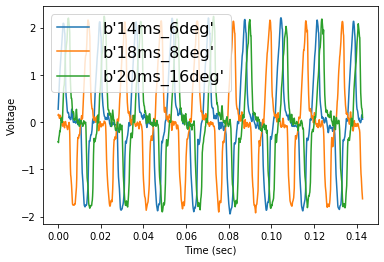

In [ ]:
legendkey = list()
t = np.arange(0,1000/7000,1/7000)
for i in (22,37,534):#,36,46):
  plt.plot(t,trainingX[i,1000:2000,1])
  legendkey.append(trainingState[i])
plt.legend(legendkey,loc='upper left', prop={'size':16})
plt.xlabel("Time (sec)")
plt.ylabel("Voltage")
plt.savefig('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Visualizations/PZTsignals.png',dpi=300)

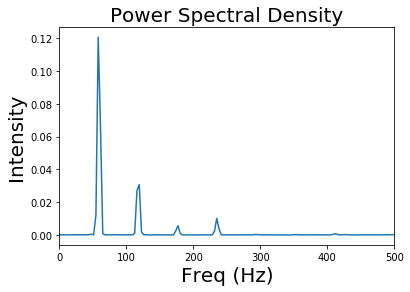

In [ ]:
# Option 1.1: Welch filter on the data This shows where frequencies are
from scipy import signal
fs = 7000
f, trainingX_welch = signal.welch(trainingX, fs, nperseg=2056, axis=1)

plt.plot(f,trainingX_welch[100,0:2790,0])
plt.xlim(0,500)
plt.xlabel("Freq (Hz)", fontsize=20)
plt.ylabel("Intensity", fontsize=20)
plt.title("Power Spectral Density", fontsize=20)
plt.savefig('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Visualizations/pwelch.png',dpi=300)

In [ ]:
# Option1.2: Manual preprocessing (lowpass filter)
from scipy import signal
import matplotlib.pyplot as plt

fs = 7000
b, a = signal.butter (N=2, Wn=(55/(fs/2), 65/(fs/2)), btype='stop') #Lowpass filter to pass anything below 50hz utility noise
trainingX_opt1 = signal.lfilter(b,a,trainingX, axis=1)

b, a = signal.butter (N=2, Wn=(115/(fs/2), 125/(fs/2)), btype='stop') #Lowpass filter to pass anything below 50hz utility noise
trainingX_opt1 = signal.lfilter(b,a,trainingX_opt1, axis=1)

b, a = signal.butter (N=2, Wn=(175/(fs/2), 185/(fs/2)), btype='stop') #Lowpass filter to pass anything below 50hz utility noise
trainingX_opt1 = signal.lfilter(b,a,trainingX_opt1, axis=1)

b, a = signal.butter (N=2, Wn=(235/(fs/2), 245/(fs/2)), btype='stop') #Lowpass filter to pass anything below 50hz utility noise
trainingX_opt1 = signal.lfilter(b,a,trainingX_opt1, axis=1)

b, a = signal.butter (N=2, Wn=55/(fs/2), btype='low') #Lowpass filter to pass anything below 50hz utility noise
trainingX_opt2 = signal.lfilter(b,a,trainingX_opt1, axis=1)

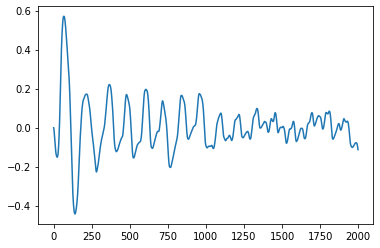

In [ ]:
plt.plot(trainingX_opt2[500,0:2000,0])

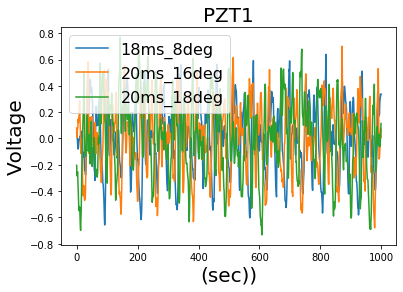

In [ ]:
legendkey = list()
for i in (37,534,46):
  plt.plot(trainingX_opt1[i,1000:2000,1])
  legendkey.append(trainingState[i])
plt.legend(['18ms_8deg','20ms_16deg','20ms_18deg'],loc='upper left', prop={'size':16})

plt.xlabel("(sec))", fontsize=20)
plt.ylabel("Voltage", fontsize=20)
plt.title("PZT1", fontsize=20)
plt.savefig('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Visualizations/opt1.png',dpi=300)

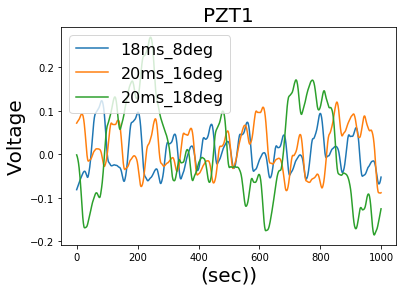

In [ ]:
legendkey = list()
for i in (37,534,46):
  plt.plot(trainingX_opt2[i,1000:2000,1])
  legendkey.append(trainingState[i])
plt.legend(['18ms_8deg','20ms_16deg','20ms_18deg'],loc='upper left', prop={'size':16})

plt.xlabel("(sec))", fontsize=20)
plt.ylabel("Voltage", fontsize=20)
plt.title("PZT1", fontsize=20)
plt.savefig('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Visualizations/opt2.png',dpi=300)

In [ ]:
# Option3: Wavelet transformation 
# Downsample the signals in preparation for Wavelet transform
from scipy import signal

sub_trainingX_opt31 = signal.resample(trainingX, 128, axis=1)

/usr/local/lib/python3.6/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


complex128


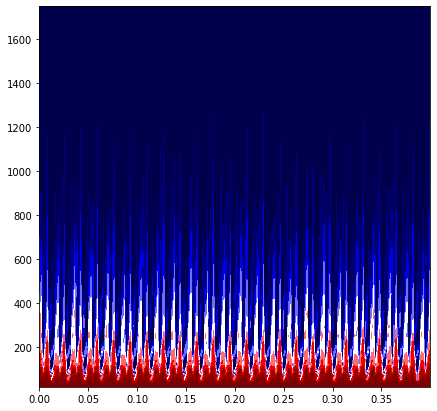

In [ ]:
# Option3: Wavelet transformation 
# Visualize a sample transformation
import pywt
def run_wavelet_single(signal, scales, waveletname, dt):
  coeff, freq = pywt.cwt(signal, scales, waveletname, dt)
  return coeff, freq

#Options for wavelets: cmor and morl
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Frequency (Hz)', 
                 xlabel = 'Time'):
    
  dt = time[1] - time[0]
  coeff, freq = run_wavelet_single(signal, scales, waveletname, dt*2)
  power = (abs(coeff)) ** 2
  levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
  contourlevels = np.log2(levels)
  print (coeff.dtype)
  
  fig, ax = plt.subplots(figsize=(7, 7))
  im = ax.contourf(time, freq[0:100], np.log2(power[0:100]), contourlevels, extend='both',cmap=cmap)

  # ax.set_xlabel("(sec)", fontsize=26)
  # ax.set_ylabel("Freq (Hz)", fontsize=26)
  # ax.set_title("CMOR Wavelet Transform", fontsize=26)
  plt.savefig('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Visualizations/cmor2.png',dpi=300)

  # ax.set_title(title, fontsize=20)
  # ax.set_ylabel(ylabel, fontsize=18)
  # ax.set_xlabel(xlabel, fontsize=18)
  
  # yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
  # ax.set_yticks(np.log2(yticks))
  # ax.set_yticklabels(yticks)
  # ax.invert_yaxis()
  # ylim = ax.get_ylim()
  # ax.set_ylim(ylim[0], -1)

dt = 1/7000
time = np.arange(2800)*dt
scales = range(1,128)
signal = trainingX[20,:,1]
plot_wavelet(time, signal, scales)

In [ ]:
# Option3: Wavelet transformation 
# Perform wavelet transformation
import pywt

def prep_wavelet_images(signal, scales, dt, waveletname='cmor'):
  coeff, freq = pywt.cwt(signal, scales, waveletname, sampling_period=dt, axis=1)
  return ((abs(coeff)) ** 2).astype('float16'), freq

dt = 1/7000
scales = np.arange(1,10)
signal = sub_trainingX_opt31[:,:,0:3]
coeff, freq = prep_wavelet_images(signal, scales, dt)
coeff = np.transpose(coeff,(1,0,2,3)) #shape becomes (nsamples, 63, 700, sensorcount)

/usr/local/lib/python3.6/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


In [ ]:
print (coeff.shape)

(1650, 63, 1400, 3)


In [ ]:
# Option 1:
# 1D CONVNET (from Zhe)
# This works well with the following:
# - 3PZT for stall estimation. standardized. very good.
# - 3PZT + 1SG for stall estimation. standardized. very good.
# - 3PZT + 1SG for STATE estimation. standardized. very good (train99, val89).

# Importing the Keras libraries and packages
import pickle
import keras
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.metrics import sparse_categorical_accuracy
from keras import optimizers
from keras import regularizers
from keras import initializers
from keras import utils  
from keras.utils.np_utils import to_categorical


# convert data to categorical
encoder = preprocessing.LabelEncoder()

state_categorical = encoder.fit_transform(trainingState)
stall_categorical = encoder.fit_transform(trainingStall)
trainingY = state_categorical ###Change this based on the output of interest###

# Initializing the CNN
classifier = Sequential()
REG = 1e-5
class_weight = {0:1., 1:4.}
leakyrelu = LeakyReLU(alpha=0.05)
windowSize = 2800
sensorCount = 4

# Conv layers
classifier.add(Conv1D(64, 5, input_shape=(windowSize, sensorCount), strides=1))
classifier.add(Dropout(rate=0.2)) #Fraction of inputs to drop

classifier.add(Conv1D(64, 5, activation='relu'))
classifier.add(Dropout(0.2))

classifier.add(Conv1D(64, 5, activation='relu'))
classifier.add(MaxPooling1D(pool_size=2, stride=2))
classifier.add(Dropout(0.2))

classifier.add(Conv1D(128, 3, activation='relu'))
classifier.add(MaxPooling1D(pool_size=2, stride=2))
classifier.add(Dropout(0.2))

classifier.add(Conv1D(128, 3, activation='relu'))
classifier.add(MaxPooling1D(pool_size=2, stride=2))
classifier.add(Dropout(0.2))
classifier.add(Flatten())

# OUTPUT LAYER
classifier.add(Dense(max(trainingY)+1, activation="softmax"))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# TRAIN THE MODEL
# Save the model weights after each epoch if the validation loss decreased
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/tmpModel_ignore.hdf5', verbose=0, save_best_only=True)
history = classifier.fit(trainingX, trainingY, epochs = 45, batch_size=128, verbose = 1, validation_split=0.1, callbacks = [checkpointer])

In [ ]:
# 2D CONVNET (from Ataspinar + Zhe)
# This works well with the following:
# - 

# Importing the Keras libraries and packages
import pickle
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.metrics import sparse_categorical_accuracy
from keras import optimizers
from keras import regularizers
from keras import initializers
from keras import utils  
from keras.utils.np_utils import to_categorical


# convert data to categorical
encoder = preprocessing.LabelEncoder()

state_categorical = encoder.fit_transform(trainingState)
stall_categorical = encoder.fit_transform(trainingStall)
trainingY = state_categorical ###Change this based on the output of interest###

# Initializing the CNN
classifier = Sequential()
REG = 1e-5
class_weight = {0:1., 1:4.}
leakyrelu = LeakyReLU(alpha=0.05)
windowSize = 2800
sensorCount = 4

# Conv layers
classifier.add(Conv2D(64, (5,5), input_shape=(9, 128, 3), activation='relu', padding='same'))

classifier.add(Conv2D(64, (5,5), activation='relu', padding='same'))
classifier.add(MaxPooling2D(pool_size=(3,3)))

classifier.add(Conv2D(64, (5,5), activation='relu', padding='same'))
classifier.add(Dropout(0.5))

classifier.add(Conv2D(128, (3,3), activation='relu', padding='same'))
#classifier.add(MaxPooling2D(pool_size=(3,3)))

classifier.add(Conv2D(128, (3,3), activation='relu', padding='same'))
classifier.add(Dropout(0.5))

classifier.add(Conv2D(128, (3,3), activation='relu', padding='same'))
#classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Flatten())
#classifier.add(Dense(100, activation="relu"))

# OUTPUT LAYER
classifier.add(Dense(max(trainingY)+1, activation="softmax"))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# TRAIN THE MODEL
# Save the model weights after each epoch if the validation loss decreased
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/tmpModelbad.hdf5', verbose=0, save_best_only=True)
history = classifier.fit(coeff, trainingY, epochs = 2, batch_size=128, verbose = 1, validation_split=0.1, callbacks = [checkpointer])

Train on 8316 samples, validate on 924 samples
Epoch 1/2
8316/8316 [==============================] - 3s 305us/step - loss: 4.1909 - acc: 0.0146 - val_loss: 4.1902 - val_acc: 0.0097
Epoch 2/2
8316/8316 [==============================] - 2s 189us/step - loss: 4.1898 - acc: 0.0159 - val_loss: 4.1909 - val_acc: 0.0097


In [ ]:
print (classifier.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 9, 128, 64)        4864      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 9, 128, 64)        102464    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 42, 64)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 3, 42, 64)         102464    
_________________________________________________________________
dropout_18 (Dropout)         (None, 3, 42, 64)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 3, 42, 128)        73856     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 3, 42, 128)       

In [ ]:
# 02/22/2020 not working because the model doesn't have logs??
from keras.models import load_model

stateclassifier = load_model('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/Dec1_models/Dec1_model2_state_val89_4sens.hdf5')
print (stateclassifier.summary())

fig = plt.figure()
plt.plot(stateclassifier.logs['acc'])
plt.plot(stateclassifier.logs['val_acc'])
plt.title ('Bandstop + Low-Pass + 1DCNN State Predictor')
plt.ylabel ('Accuracy')
plt.xlabel ('Epoch')
plt.legend (['Train', 'Val'], loc='upper left')
plt.show()
fig.savefig('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/Visualizations/1DCNN_training.png',dpi=300)



In [ ]:
# 02/22/2020 create confusion matrix
import keras
stateclassifier = keras.models.load_model('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/Dec1_models/Dec1_model2_state_val89_4sens.hdf5')

#Process the data to reproduce the validation data used in training
trainingX = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingX_Dec1.npy')
valX = trainingX[8316:,:,:]
trainingState = np.load('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Dec1_Test1/allExamples/std_trainingState_Dec1.npy')
encoder = preprocessing.LabelEncoder()
state_categorical = encoder.fit_transform(trainingState)
valY = state_categorical[8316:]

In [ ]:
#02/22/2020 create confusion matrix
classes = list(allState)
classes = [cls.decode("utf-8") for cls in classes]
import tensorflow as tf
y_pred = stateclassifier.predict_classes(valX)
con_mat = tf.math.confusion_matrix(labels=valY, predictions=y_pred)

sess = tf.Session()
with sess.as_default():
  con_mat_np = con_mat.eval()

con_mat_norm = np.around(con_mat_np.astype('float') / con_mat_np.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

con_mat_df.info()
#con_mat_df_closeup = con_mat_df.ix[48:57,48:57]
#con_mat_df_closeup = con_mat_df_closeup [48:57]

In [ ]:
print (len(classes))

66


In [ ]:
print (con_mat_df_closeup)

            18ms_8deg  18ms_10deg  18ms_12deg  ...  18ms_20deg  20ms_0deg  20ms_2deg
18ms_8deg        0.60        0.00        0.00  ...         0.0        0.0       0.10
18ms_10deg       0.00        0.53        0.42  ...         0.0        0.0       0.00
18ms_12deg       0.00        0.29        0.71  ...         0.0        0.0       0.00
18ms_14deg       0.00        0.00        0.00  ...         0.0        0.0       0.00
18ms_16deg       0.00        0.00        0.00  ...         0.0        0.0       0.00
18ms_18deg       0.00        0.00        0.00  ...         0.0        0.0       0.00
18ms_20deg       0.00        0.00        0.00  ...         1.0        0.0       0.00
20ms_0deg        0.00        0.00        0.00  ...         0.0        1.0       0.00
20ms_2deg        0.19        0.00        0.00  ...         0.0        0.0       0.81

[9 rows x 9 columns]


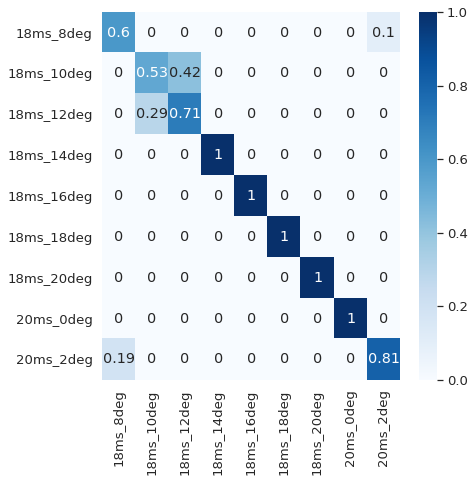

In [ ]:
#02/22/2020 create confusion matrix
import seaborn as sns
figure = plt.figure(figsize=(7,7))
sns.heatmap(con_mat_df_closeup, annot=True,cmap=plt.cm.Blues)
sns.set(font_scale=1.4)
plt.tight_layout()
# plt.ylabel('True state')
# plt.xlabel('Predicted state')
plt.show()
figure.savefig ('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/Visualizations/closeupConfusion_largelabels.png', dpi=300)

<Figure size 432x288 with 0 Axes>

In [ ]:
### IGNORE. SOME TRYOUT FOR ESTIMATION STUFF
from keras.models import load_model
stateclassifier = load_model('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/Dec1_models/Dec1_model2_state_val89_4sens.hdf5')
stateList = pickle.load (open("/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/statelist.pickle", "rb" ))

def predict1d(data, model, stateList):
  data_rsp = np.copy(data).reshape((1,2800,4))
  prediction = model.predict(data_rsp)
  predictedlabel = np.argmax (prediction)
  predictedstate = stateList[predictedlabel]
  return predictedstate

data = trainingX[100,:,:]
print (data.shape)
state_prob = predict1d(data.T, stateclassifier, stateList)
print (state_prob)

(2800, 4)
b'12ms_0deg'


In [ ]:
#Visualizations
from keras.utils import plot_model
import matplotlib.pyplot as plt

def visualizemodel():
  plot_model(classifier, to_file='/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/Visualizations/1DCNN_model.png', expand_nested=False)

def visualizetraining():
  fig = plt.figure()
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title ('Bandstop + Low-Pass + 1DCNN State Predictor')
  plt.ylabel ('Accuracy')
  plt.xlabel ('Epoch')
  plt.legend (['Train', 'Val'], loc='upper left')
  plt.show()
  fig.savefig('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/Visualizations/1DCNN_training.png',dpi=300)

#classifier = keras.models.load_model('/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/tmpModel.hdf5')
#visualizetraining()

In [ ]:
print (trainingX.shape)
print (trainingY.shape)

(9240, 2800, 4)
(9240,)


In [ ]:
print (classifier.predict(trainingX[0:10,:,:]))

In [ ]:
# SET UP CONVNET (OLD MODEL WORSE PREDICTIONS)
# This works well with the following:
# - 3PZT for stall estimation. non-standardized (standardized not working!!!)
# - 
# Importing the Keras libraries and packages
import pickle
import keras
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.metrics import sparse_categorical_accuracy
from keras import optimizers
from keras import regularizers
from keras import initializers
from keras import utils  

# convert data to categorical
encoder = preprocessing.LabelEncoder()

state_categorical = encoder.fit_transform(trainingState)
stall_categorical = encoder.fit_transform(trainingStall)
trainingY = stall_categorical ###Change this based on the output of interest###

# Initializing the CNN
classifier = Sequential()
REG = 1e-5
class_weight = {0:4., 1:1.}
leakyrelu = LeakyReLU(alpha=0.05)

# Conv layers
classifier.add(Conv1D(4, 100, input_shape=(windowSize,3), strides=1))
classifier.add(leakyrelu)
classifier.add(MaxPooling1D())
classifier.add(Conv1D(16, 50, activation='relu'))
classifier.add(Conv1D(32, 50, activation='relu'))
classifier.add(MaxPooling1D())
classifier.add(Conv1D(32, 50, activation='relu'))
classifier.add(Conv1D(32, 50, activation='relu'))
classifier.add(MaxPooling1D())
classifier.add(Flatten())
classifier.add(Dense(100, activation="relu"))

# OUTPUT LAYER
classifier.add(Dense(max(trainingY)+1, activation="softmax"))

# Compiling the CNN
customAdam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
customAdamax = optimizers.Adamax(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# TRAIN THE MODEL
# Save the model weights after each epoch if the validation loss decreased
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/Shared drives/WindTunnelTests-Feb2019/Nov2019_Tests/Baseline_Tests/Kerasfiles/tmpModel.hdf5', verbose=0, save_best_only=True)
history = classifier.fit(trainingX[:,:,0:3], trainingY, epochs = 200, batch_size=1024, verbose = 1, validation_split=0.15, shuffle=False, callbacks = [checkpointer])


